<a href="https://colab.research.google.com/github/toby-j/NLP-Experiments-on-GoEmotions-dataset/blob/main/Model_Architecture_(Ex_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
---
This notebook is a pre-processing experiment, which introduces spell-checking on a standardised control model trained on the GoEmotions dataset. As as group we developed the control model to ensure an accurate and trustworthy comparson of results from each of our experiments.

# Imports and Loading

In [ ]:
try:
  !pip install datasets
  !pip install transformers
  !pip install language-tool-python
  !pip install contractions
  !apt-get install libhunspell-dev
  !pip install hunspell
except:
  import locale
  locale.getpreferredencoding = lambda: "UTF-8"
  !pip install datasets
  !pip install transformers
  !pip install language-tool-python
  !pip install contractions
  !apt-get install libhunspell-dev
  !pip install hunspell

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached contractions-0.1.73-py2.py3-none-any.whl (8.7 kB)
  Using cached textsearch-0.0.24-py2.py3-none-any.whl (7.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 32.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libhunspell-dev is already the newest version (1.7.0-2build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from numpy import *
import numpy as np

# Spelling imports
import hunspell
import re
import spacy
import language_tool_python
import spacy
import contractions

from collections import defaultdict

# Huggingface
from transformers import TFBertForSequenceClassification, TFRobertaForSequenceClassification, AutoTokenizer, TFRobertaModel, RobertaTokenizer, TFBertModel
from datasets import Dataset, load_dataset, concatenate_datasets, DatasetDict

#Metrics
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Classnames

In [ ]:
raw_dataset = load_dataset("go_emotions")

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
{'0': 'admiration',
 '1': 'amusement',
 '2': 'anger',
 '3': 'annoyance',
 '4': 'approval',
 '5': 'caring',
 '6': 'confusion',
 '7': 'curiosity',
 '8': 'desire',
 '9': 'disappointment',
 '10': 'disapproval',
 '11': 'disgust',
 '12': 'embarrassment',
 '13': 'excitement',
 '14': 'fear',
 '15': 'gratitude',
 '16': 'grief',
 '17': 'joy',
 '18': 'love',
 '19': 'nervousness',
 '20': 'optimism',
 '21': 'pride',
 '22': 'realization',
 '23': 'relief',
 '24': 'remorse',
 '25': 'sadness',
 '26': 'surprise',
 '27': 'neutral'}

all_class_names = [
    "admiration",
    "amusement",
    "anger",
    "annoyance",
    "approval",
    "caring",
    "confusion",
    "curiosity",
    "desire",
    "disappointment",
    "disapproval",
    "disgust",
    "embarrassment",
    "excitement",
    "fear",
    "gratitude",
    "grief",
    "joy",
    "love",
    "nervousness",
    "optimism",
    "pride",
    "realization",
    "relief",
    "remorse",
    "sadness",
    "surprise",
    "neutral",
]

# Global Functions

## Display

In [ ]:
def plot_graphs(vals, name, y_lim = 99999, y_scale = "linear", legend = []):
  """
  vals : list[list]
    a list of (a list of values for each epoch) - default expects [train values, test values]
  name : str
    name of type of values (goes on y-axis) eg "loss", "accuracy"
  y_lim : int
    greatest value on y axis is min(y_lim, max value in vals)
  y_scale : str
    controls scale of y-axis eg "linear", "logarithmic
  legend : list[str]
    allows for a custom legend
  """
  for val in vals:
    plt.plot(val)

  plt.ylabel(name)
  plt.xlabel("epoch")
  plt.xlim(0, len(vals[0]) - 1)
  if y_scale == "linear":
    plt.ylim(min(0, array(vals).min()), min(y_lim, array(vals).max()))
  plt.yscale(y_scale)

  if len(legend) > 0:
    plt.legend(legend)
  else:
    plt.legend(["train", "test"])

  plt.show()

  print(['{:.2e}'.format(v[-1]) for v in vals])

In [ ]:
def output_metrics(model, test_data, test_labels):
  predictions = model.predict(test_data)

  y_pred  = np.argmax(predictions, axis=-1)
  y_test = np.argmax(test_labels, axis=-1)

  print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
  print(f'F1 score: {f1_score(y_test, y_pred, average="weighted")}')
  print(f'Precision score: {precision_score(y_test, y_pred, average="weighted")}')
  print(f'Recall score: {recall_score(y_test, y_pred, average="weighted")}')

In [ ]:
# Plot low, med, high spelling corrections based on Levenshtein distance
def plot_corrections(corrections):
    labels = list(corrections.keys())
    values = [len(corrections[label]) for label in labels]
    plt.bar(labels, values)
    plt.xlabel('Edit Distance Category')
    plt.ylabel('Number of Corrections')
    plt.title('Correction Counts by Edit Distance Category')
    plt.show()

In [ ]:
def plot_confusion_matrix(model_input, test_data, test_labels):
  predictions = model_input.predict(test_data)

  y_pred  = np.argmax(predictions, axis=-1)
  y_test = np.argmax(test_labels, axis=-1)

  confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

  labels = list(set(y_test) | set(y_pred))
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)

  fig, ax = plt.subplots(figsize=(10, 8))
  cm_display.plot(ax=ax)
  
  plt.show()

## Utility

Functions shared across all experiments.

In [ ]:
def bert_tokenize_dataset(data):
    # Keys of the returned dictionary will be added to the dataset as columns
    tokenizer_out = bert_tokenizer(data["text"], padding = "max_length", truncation = True, max_length = seq_len) # Sets length of tokenized string to mean token sequence length
    for key in tokenizer_out:
      data[key] = tokenizer_out[key]
    return data

def roberta_tokenize_dataset(data):
    # Keys of the returned dictionary will be added to the dataset as columns
    tokenizer_out = roberta_tokenizer(data["text"], padding = "max_length", truncation = True, max_length = seq_len) # Sets length of tokenized string to mean token sequence length
    for key in tokenizer_out:
      data[key] = tokenizer_out[key]
    return data

## Variables
Variables that are shared across all experiments.

In [ ]:
#Load Tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
roberta_model = TFRobertaModel.from_pretrained('roberta-base')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


# Control

## Dataset Preparation
The following section describes the standardised way in which the dataset is prepared for training. These steps include the filtering of classes to ensure the dataset only includes the required 14. The prepartaion of the dataset has been controlled (kept the same) for each experiment to enable accurate and fair measuring of the results yielded by the modified variable in each experiment.

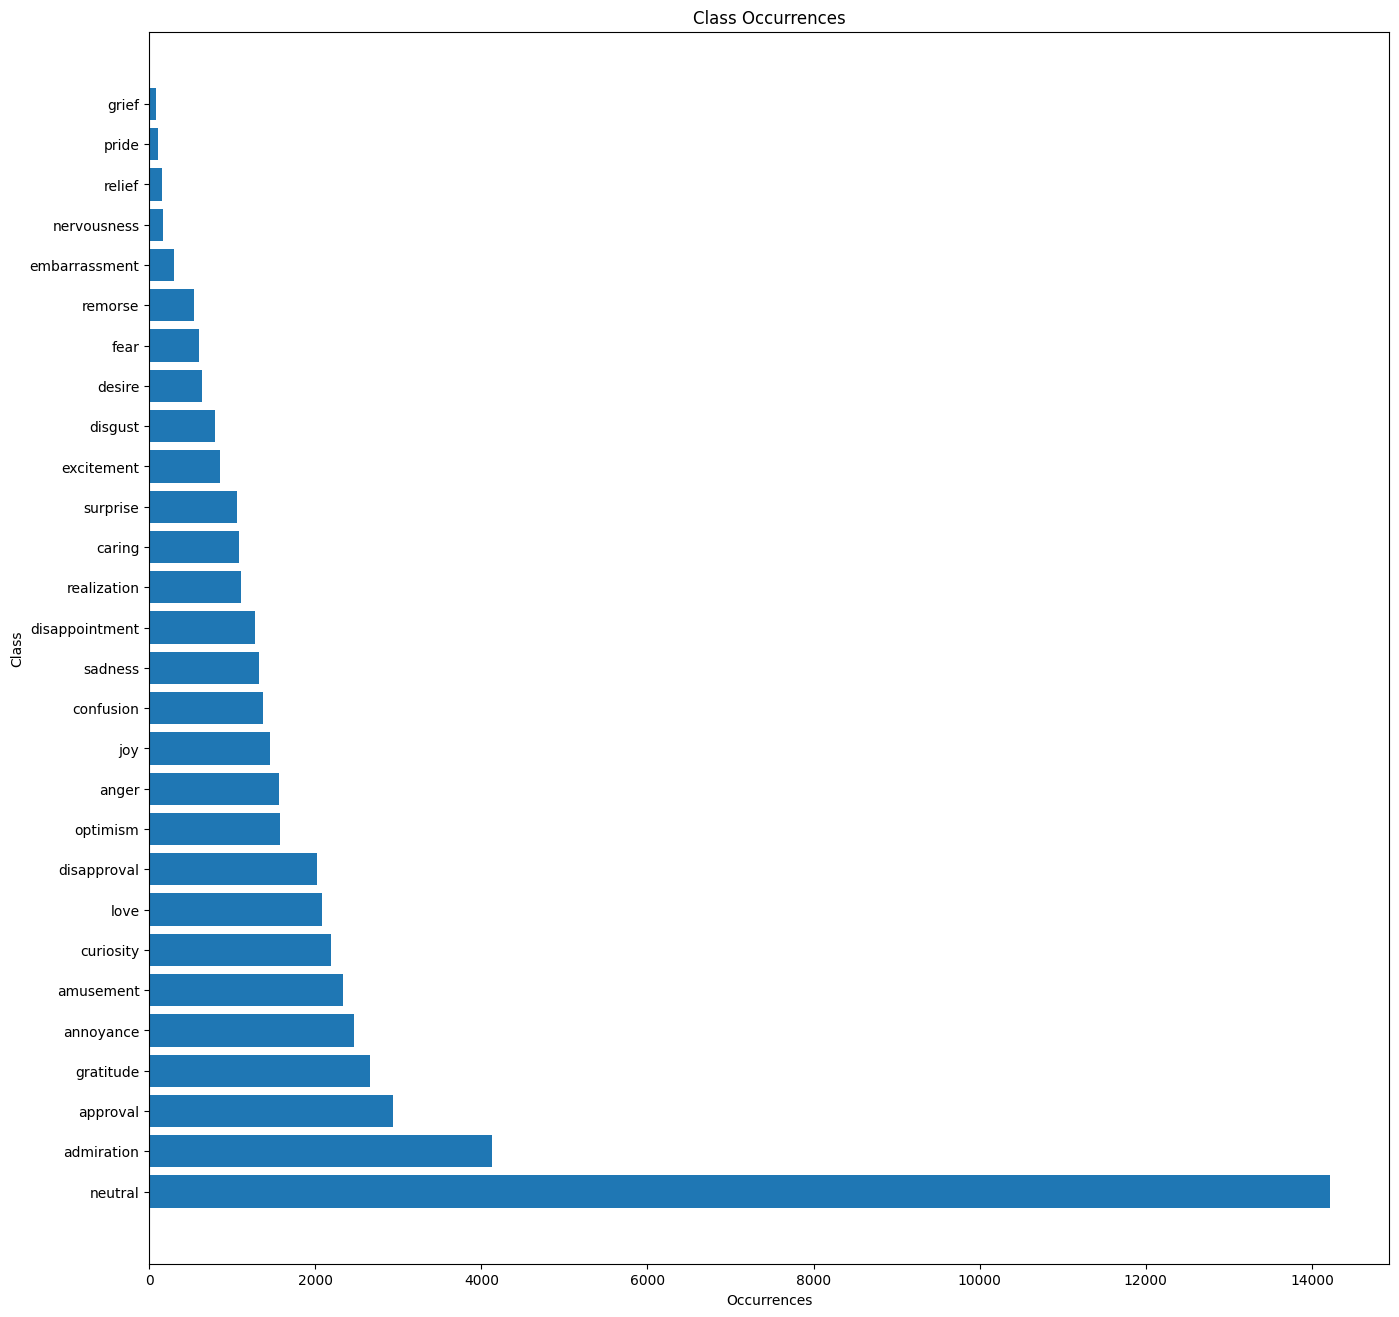

In [ ]:
def count_classes(class_names):
    class_counts = {class_name: 0 for class_name in class_names}

    for item in raw_dataset['train']:
      for class_name in item['labels']:
            class_counts[all_class_names[class_name]] += 1
    return class_counts

feature_distribution = dict(sorted(count_classes(all_class_names).items(), key=lambda item: item[1])) 

def plot_class_occurrences(class_counts):
    # Get the class names and occurrence counts
    class_names = list(class_counts.keys())
    class_counts = list(class_counts.values())

    # Create a horizontal bar chart
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.barh(class_names, class_counts)

    # Set the axis labels and title
    ax.set_xlabel('Occurrences')
    ax.set_ylabel('Class')
    ax.set_title('Class Occurrences')

    # Invert the y-axis to show the classes in descending order of occurrences
    ax.invert_yaxis()

    # Show the plot
    plt.show()

plot_class_occurrences(feature_distribution)

In [ ]:
# Get top 14 most frequently occuring keys in dataset and fetch their indices
class_names = list(feature_distribution.keys())[-14:]
class_name_idxs = [all_class_names.index(x) for x in class_names]
print(list(zip(class_names, class_name_idxs)))

[('sadness', 25), ('confusion', 6), ('joy', 17), ('anger', 2), ('optimism', 20), ('disapproval', 10), ('love', 18), ('curiosity', 7), ('amusement', 1), ('annoyance', 3), ('gratitude', 15), ('approval', 4), ('admiration', 0), ('neutral', 27)]


In [ ]:
# Here's the indexs of our selected classes
print(class_name_idxs)

[25, 6, 17, 2, 20, 10, 18, 7, 1, 3, 15, 4, 0, 27]


## Filtering

We'll now filter the dataset so it only contains the classes we're interested in

In [ ]:
def flatten_list(arr):
  return [num for sublist in arr for num in sublist]

In [ ]:
# If it has at least one label that is the selected subset of classes it's valid
def is_valid(data_item):
  return not (len(data_item["labels"]) == 1 and data_item["labels"][0] not in class_name_idxs)

# Remove classes that don't have a label in our 14 selected classes 
def remove_invalid_classes(data_item):
  data_item["labels"] = [label for label in data_item["labels"] if label in class_name_idxs] 

  for label in data_item["labels"]:
    assert label in class_name_idxs

  data_item["labels"] = [class_name_idxs.index(label) for label in data_item["labels"]][0:1] # "Rename" old labels

  return data_item

def one_hot_labels(data_item):
  data_item["labels"] = sum(to_categorical(data_item["labels"], len(class_name_idxs)), axis = 0)
  return data_item

# Apply dataset processing
dataset = raw_dataset.filter(lambda x: is_valid(x)).map(remove_invalid_classes)

# One-hot the labels
dataset_control = dataset.map(one_hot_labels)

Filter:   0%|          | 0/43410 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

Map:   0%|          | 0/4756 [00:00<?, ? examples/s]

Map:   0%|          | 0/4728 [00:00<?, ? examples/s]

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

Map:   0%|          | 0/4756 [00:00<?, ? examples/s]

Map:   0%|          | 0/4728 [00:00<?, ? examples/s]

## Tokenisation

In [ ]:
seq_lens = [len(bert_tokenizer(x)["input_ids"]) for x in dataset_control["train"]["text"]]

seq_len = int(ceil(mean(seq_lens) + std(seq_lens)))

dataset_tokenized = dataset_control.map(bert_tokenize_dataset)

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

Map:   0%|          | 0/4756 [00:00<?, ? examples/s]

Map:   0%|          | 0/4728 [00:00<?, ? examples/s]

## Model Definition
In this experiment. We are not changing the model, so both utilise this definition.

In [ ]:
# Resets TF graph to release memory
tf.keras.backend.clear_session()

def define_control_model():
  input_ids = Input(shape = (seq_len,), dtype = "int32", name = "input_ids")
  token_type_ids = Input(shape = (seq_len,), dtype = "int32", name = "token_type_ids")
  attention_masks = Input(shape = (seq_len,), dtype = "int32", name = "attention_mask")

  bert = TFBertForSequenceClassification.from_pretrained("bert-base-cased", num_labels = 14)

  inputs = {"input_ids": input_ids, "attention_mask": attention_masks, "token_type_ids": token_type_ids}
  outputs = bert(inputs)
  model = outputs.logits
  
  model = Dense(14, activation = "softmax")(model)

  model = Model(inputs = [input_ids, token_type_ids, attention_masks], outputs = model)

  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

  model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

  return model

define_control_model().summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  108321038  ['attention_mask[0][0]',         
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'input_ids[0][0]',          

In [ ]:
batch_size = 128

def create_test_dataset(ds):
  return ds["train"].to_tf_dataset( # 1000 for speed debugging, for full training, comment out the ".select(n)"
  columns = ["input_ids", "token_type_ids", "attention_mask"],
  label_cols = ["labels"],
  batch_size = batch_size,
  shuffle = True,
)
  
def create_train_dataset(ds):
  return ds["test"].to_tf_dataset( # 1000 for speed debugging, for full training, comment out the ".select(n)"
  columns = ["input_ids", "token_type_ids", "attention_mask"],
  label_cols = ["labels"],
  batch_size = batch_size,
  shuffle = True,
)
  
early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 8, restore_best_weights = True)

## Control Training

In [ ]:
# Train the model with default learning rate
control_model = define_control_model()

control_tf_test_dataset = create_test_dataset(dataset_tokenized)
control_tf_train_dataset = create_train_dataset(dataset_tokenized)

# Create a variable to use for our metrics for our display functions. This is used by all experiments.
control_test_display_item = list(control_tf_test_dataset)[1]
control_test_data, control_test_labels = control_test_display_item

control_history = control_model.fit(control_tf_train_dataset, validation_data = control_tf_test_dataset , epochs = 40, callbacks = [early_stopping]).history

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/40
37/37 [==============================] - 74s 681ms/step - loss: 2.0241 - accuracy: 0.4061 - val_loss: 1.6814 - val_accuracy: 0.4907
Epoch 2/40
37/37 [==============================] - 19s 528ms/step - loss: 1.4124 - accuracy: 0.5711 - val_loss: 1.4541 - val_accuracy: 0.5669
Epoch 3/40
37/37 [==============================] - 18s 491ms/step - loss: 0.9916 - accuracy: 0.7018 - val_loss: 1.4603 - val_accuracy: 0.5731
Epoch 4/40
37/37 [==============================] - 17s 469ms/step - loss: 0.6380 - accuracy: 0.8065 - val_loss: 1.7251 - val_accuracy: 0.5624
Epoch 5/40
37/37 [==============================] - 17s 470ms/step - loss: 0.3940 - accuracy: 0.8852 - val_loss: 1.9064 - val_accuracy: 0.5391
Epoch 6/40
37/37 [==============================] - 16s 447ms/step - loss: 0.2268 - accuracy: 0.9334 - val_loss: 2.0126 - val_accuracy: 0.5538
Epoch 7/40
37/37 [==============================] - 16s 447ms/step - loss: 0.1351 - accuracy: 0.9547 - val_loss: 2.2365 - val_accuracy: 0.5333

## Metrics

4/4 [==============================] - 2s 10ms/step
Accuracy score: 0.625
F1 score: 0.6024899825681076
Precision score: 0.6331929116142478
Recall score: 0.625
4/4 [==============================] - 0s 10ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


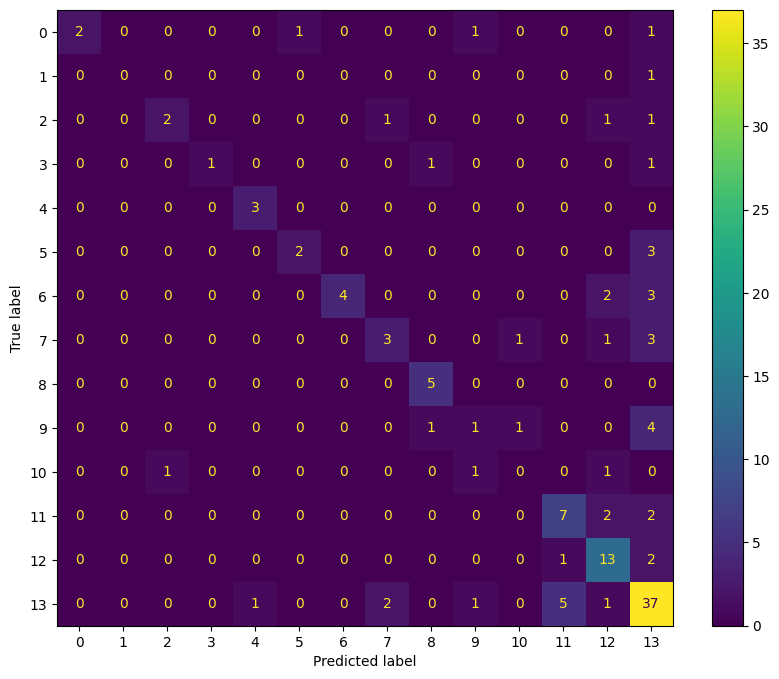

In [ ]:
# plot_graphs([control_history["lr"]], "learning_rate", legend = ["lr"], y_scale = "log")
output_metrics(control_model, control_test_data, control_test_labels)
plot_confusion_matrix(control_model, control_test_data, control_test_labels)

# Experiment 3.0: Using RoBERTa instead of BERT
Next I'll expand contracted words, for example "don't" and "they're" into their expanded form. My justification for this is all expanded and contracted words will now have the same token. Instead of being treated as seperate tokens as they will be a mix of contracted and expanded forms.

This will reduce the vocabulary size, which could improve the performance of our model. Therefore, I believe it's a worthwhile experiment.

## Preparation

In [ ]:
# Make another copy to use for 1.1
dataset_3 = dataset_control.copy()

In [ ]:
batch_size = 128

def create_roberta_test_dataset(ds):
  return ds["train"].to_tf_dataset( # 1000 for speed debugging, for full training, comment out the ".select(n)"
  columns = ["input_ids", "attention_mask"],
  label_cols = ["labels"],
  batch_size = batch_size,
  shuffle = True,
)
  
def create_roberta_train_dataset(ds):
  return ds["test"].to_tf_dataset( # 1000 for speed debugging, for full training, comment out the ".select(n)"
  columns = ["input_ids", "attention_mask"],
  label_cols = ["labels"],
  batch_size = batch_size,
  shuffle = True,
)
  
early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 8, restore_best_weights = True)

## Model definition

In [ ]:
# Resets TF graph to release memory
tf.keras.backend.clear_session()

def define_roberta_model():
  input_ids = Input(shape = (seq_len,), dtype = "int32", name = "input_ids")
  # token_type_ids = Input(shape = (seq_len,), dtype = "int32", name = "token_type_ids")
  attention_masks = Input(shape = (seq_len,), dtype = "int32", name = "attention_mask")

  roberta = TFRobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=14)

  inputs = {"input_ids": input_ids, "attention_mask": attention_masks}
  outputs = roberta(inputs)
  model = outputs.logits
  
  model = Dense(14, activation = "softmax")(model)

  model = Model(inputs = [input_ids, attention_masks], outputs = model)

  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

  model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

  return model

define_roberta_model().summary()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 tf_roberta_for_sequence_classi  TFSequenceClassifie  124656398  ['attention_mask[0][0]',         
 fication (TFRobertaForSequence  rOutput(loss=None,               'input_ids[0][0]']              
 Classification)                logits=(None, 14),                                                
                                 hidden_states=None                                           

## Tokenization

In [ ]:
dataset_3 = DatasetDict(dataset_3)

In [ ]:
experiment_3_tokenized = dataset_3.map(roberta_tokenize_dataset)

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

Map:   0%|          | 0/4756 [00:00<?, ? examples/s]

Map:   0%|          | 0/4728 [00:00<?, ? examples/s]

## Training

In [ ]:
experiment_3_tf_test_dataset = create_roberta_test_dataset(experiment_3_tokenized)
experiment_3_tf_train_dataset = create_roberta_train_dataset(experiment_3_tokenized)

# Create a variable to use for our metrics for our display functions. This is used by all experiments.
experiment_3_test_display_item = list(experiment_3_tf_test_dataset)[1]
experiment_3_test_data, experiment_3_test_labels = experiment_3_test_display_item

model_roberta = define_roberta_model()

experiment_3_history = model_roberta.fit(experiment_3_tf_test_dataset, validation_data = experiment_3_tf_train_dataset, epochs = 40, callbacks = [early_stopping]).history

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/40
298/298 [==============================] - 106s 197ms/step - loss: 1.4538 - accuracy: 0.5533 - val_loss: 1.1351 - val_accuracy: 0.6244
Epoch 2/40
298/298 [==============================] - 36s 121ms/step - loss: 1.0869 - accuracy: 0.6396 - val_loss: 1.0992 - val_accuracy: 0.6345
Epoch 3/40
298/298 [==============================] - 33s 110ms/step - loss: 0.9508 - accuracy: 0.6769 - val_loss: 1.1284 - val_accuracy: 0.6218
Epoch 4/40
298/298 [==============================] - 32s 106ms/step - loss: 0.8223 - accuracy: 0.7166 - val_loss: 1.1354 - val_accuracy: 0.6180
Epoch 5/40
298/298 [==============================] - 30s 100ms/step - loss: 0.6997 - accuracy: 0.7565 - val_loss: 1.2069 - val_accuracy: 0.6083
Epoch 6/40
298/298 [==============================] - 30s 99ms/step - loss: 0.5817 - accuracy: 0.7967 - val_loss: 1.2769 - val_accuracy: 0.6125
Epoch 7/40
298/298 [==============================] - 30s 101ms/step - loss: 0.4777 - accuracy: 0.8345 - val_loss: 1.4431 - val_ac

## Metrics

4/4 [==============================] - 2s 10ms/step
Accuracy score: 0.71875
F1 score: 0.7185793147070321
Precision score: 0.7443326697232947
Recall score: 0.71875
4/4 [==============================] - 0s 10ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


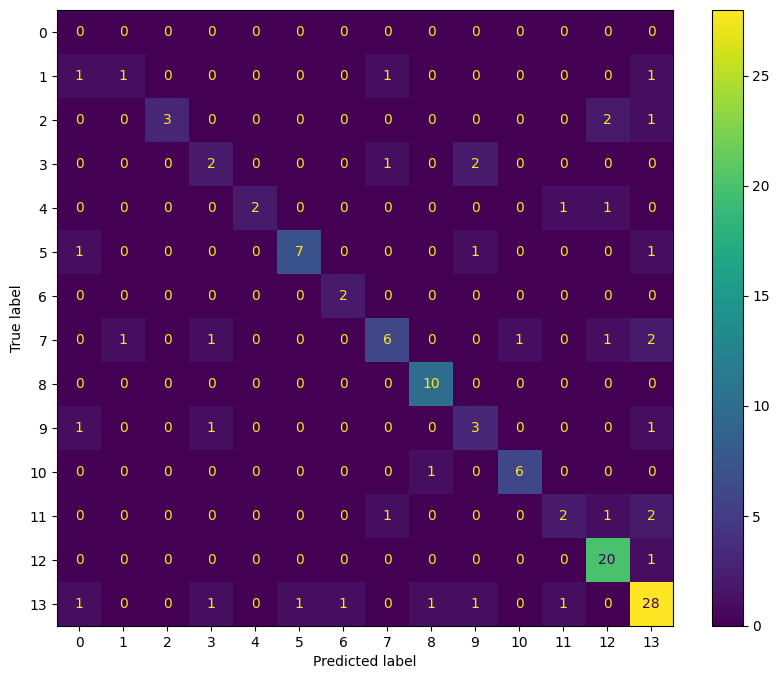

In [ ]:
output_metrics(model_roberta, experiment_3_test_data, experiment_3_test_labels)
plot_confusion_matrix(model_roberta, experiment_3_test_data, experiment_3_test_labels)

# Experiment 3.1: Adjusting Learning rate of ADAM optimizer
---







## Preparation

In [ ]:
# Make another copy to use for 1.1
dataset_3_1 = dataset_control.copy()

## Model definition

In [ ]:
# Resets TF graph to release memory
tf.keras.backend.clear_session()

def define_3_1_model():
  input_ids = Input(shape = (seq_len,), dtype = "int32", name = "input_ids")
  token_type_ids = Input(shape = (seq_len,), dtype = "int32", name = "token_type_ids")
  attention_masks = Input(shape = (seq_len,), dtype = "int32", name = "attention_mask")

  bert = TFBertForSequenceClassification.from_pretrained("bert-base-cased", num_labels = 14)

  inputs = {"input_ids": input_ids, "attention_mask": attention_masks, "token_type_ids": token_type_ids}
  outputs = bert(inputs)
  model = outputs.logits
  
  model = Dense(14, activation = "softmax")(model)

  model = Model(inputs = [input_ids, token_type_ids, attention_masks], outputs = model)

  optimizer = tf.keras.optimizers.Adamax(learning_rate = 1e-4)

  model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

  return model

define_3_1_model().summary()


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  108321038  ['attention_mask[0][0]',         
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'input_ids[0][0]',          

In [ ]:
dataset_3_1 = DatasetDict(dataset_3_1)

In [ ]:
model_3_1 = define_3_1_model()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenization

In [ ]:
experiment_3_1_tokenized = dataset_3_1.map(bert_tokenize_dataset)

## Training

In [ ]:
experiment_3_1_tf_test_dataset = create_test_dataset(experiment_3_1_tokenized)
experiment_3_1_tf_train_dataset = create_train_dataset(experiment_3_1_tokenized)

# Create a variable to use for our metrics for our display functions. This is used by all experiments.
experiment_3_1_test_display_item = list(experiment_3_1_tf_test_dataset)[1]
experiment_3_1_test_data, experiment_3_1_test_labels = experiment_3_1_test_display_item

experiment_3_1_history = model_3_1.fit(create_train_dataset(experiment_3_1_tokenized), validation_data = create_test_dataset(experiment_3_1_tokenized), epochs = 40, callbacks = [early_stopping]).history

Epoch 1/40
37/37 [==============================] - 65s 632ms/step - loss: 2.1960 - accuracy: 0.3473 - val_loss: 1.9767 - val_accuracy: 0.4238
Epoch 2/40
37/37 [==============================] - 18s 501ms/step - loss: 1.7935 - accuracy: 0.4805 - val_loss: 1.7082 - val_accuracy: 0.5067
Epoch 3/40
37/37 [==============================] - 17s 468ms/step - loss: 1.4712 - accuracy: 0.5670 - val_loss: 1.5911 - val_accuracy: 0.5282
Epoch 4/40
37/37 [==============================] - 18s 484ms/step - loss: 1.1808 - accuracy: 0.6563 - val_loss: 1.5160 - val_accuracy: 0.5549
Epoch 5/40
37/37 [==============================] - 17s 456ms/step - loss: 0.9121 - accuracy: 0.7346 - val_loss: 1.5401 - val_accuracy: 0.5564
Epoch 6/40
37/37 [==============================] - 16s 436ms/step - loss: 0.6999 - accuracy: 0.8041 - val_loss: 1.6151 - val_accuracy: 0.5618
Epoch 7/40
37/37 [==============================] - 15s 424ms/step - loss: 0.5267 - accuracy: 0.8513 - val_loss: 1.7027 - val_accuracy: 0.5438

## Metrics

4/4 [==============================] - 2s 10ms/step
Accuracy score: 0.5546875
F1 score: 0.5240718601036906
Precision score: 0.5533396724802975
Recall score: 0.5546875
4/4 [==============================] - 0s 10ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


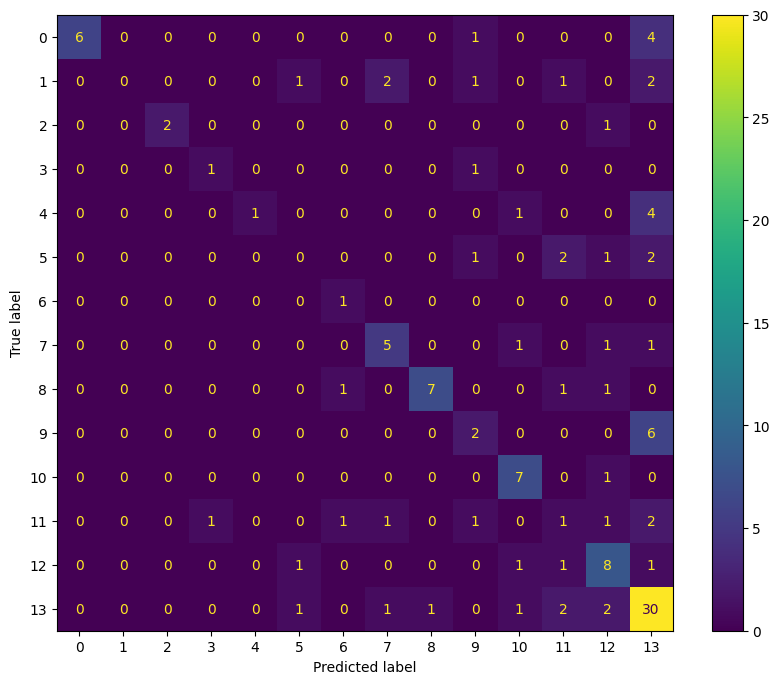

In [ ]:
output_metrics(model_3_1, experiment_3_1_test_data, experiment_3_1_test_labels)
plot_confusion_matrix(model_3_1, experiment_3_1_test_data, experiment_3_1_test_labels)

# Experiment 3.2: Adding more dense layers

## Preparation

In [ ]:
dataset_3_2 = dataset_control.copy()

In [ ]:
dataset_3_2 = DatasetDict(dataset_3_2)

## Model definition

In [ ]:
def define_3_2_model():
  input_ids = Input(shape = (seq_len,), dtype = "int32", name = "input_ids")
  token_type_ids = Input(shape = (seq_len,), dtype = "int32", name = "token_type_ids")
  attention_masks = Input(shape = (seq_len,), dtype = "int32", name = "attention_mask")

  bert = TFBertForSequenceClassification.from_pretrained("bert-base-cased", num_labels = 512)

  inputs = {"input_ids": input_ids, "attention_mask": attention_masks, "token_type_ids": token_type_ids}
  outputs = bert(inputs)
  model = outputs.logits

  model = Dense(512, activation = "relu")(model)
  model = Dropout(0.7)(model)
  model = Dense(128, activation = "relu")(model)
  model = Dropout(0.7)(model)
  model = Dense(14, activation = "softmax")(model)

  model = Model(inputs = [input_ids, token_type_ids, attention_masks], outputs = model)

  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

  model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

  return model

define_3_2_model().summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  108704000  ['attention_mask[0][0]',         
 ation_2 (TFBertForSequenceClas  rOutput(loss=None,               'input_ids[0][0]',        

In [ ]:
model_3_2 = define_3_2_model()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenization

In [ ]:
experiment_3_2_tokenized = dataset_3_2.map(bert_tokenize_dataset)

## Training

In [ ]:
experiment_3_2_tf_test_dataset = create_test_dataset(experiment_3_2_tokenized)
experiment_3_2_tf_train_dataset = create_train_dataset(experiment_3_2_tokenized)

experiment_3_2_test_display_item = list(experiment_3_2_tf_test_dataset)[1]
experiment_3_2_test_data, experiment_3_2_test_labels = experiment_3_2_test_display_item

experiment_3_2_history = model_3_2.fit(create_train_dataset(experiment_3_2_tokenized), validation_data = create_test_dataset(experiment_3_2_tokenized), epochs = 40, callbacks = [early_stopping]).history

Epoch 1/40
37/37 [==============================] - 70s 627ms/step - loss: 2.4729 - accuracy: 0.2424 - val_loss: 2.0942 - val_accuracy: 0.4269
Epoch 2/40
37/37 [==============================] - 19s 522ms/step - loss: 2.1516 - accuracy: 0.3813 - val_loss: 1.8741 - val_accuracy: 0.4555
Epoch 3/40
37/37 [==============================] - 17s 478ms/step - loss: 1.9509 - accuracy: 0.4385 - val_loss: 1.8565 - val_accuracy: 0.5082
Epoch 4/40
37/37 [==============================] - 18s 483ms/step - loss: 1.7448 - accuracy: 0.4850 - val_loss: 1.7800 - val_accuracy: 0.5228
Epoch 5/40
37/37 [==============================] - 16s 448ms/step - loss: 1.5365 - accuracy: 0.5376 - val_loss: 1.8598 - val_accuracy: 0.5081
Epoch 6/40
37/37 [==============================] - 16s 445ms/step - loss: 1.4113 - accuracy: 0.5747 - val_loss: 1.8508 - val_accuracy: 0.5151
Epoch 7/40
37/37 [==============================] - 16s 450ms/step - loss: 1.3087 - accuracy: 0.6062 - val_loss: 2.1026 - val_accuracy: 0.5236

## Metrics

4/4 [==============================] - 2s 11ms/step
Accuracy score: 0.5625
F1 score: 0.5645879339565391
Precision score: 0.5905072517942583
Recall score: 0.5625
4/4 [==============================] - 0s 10ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


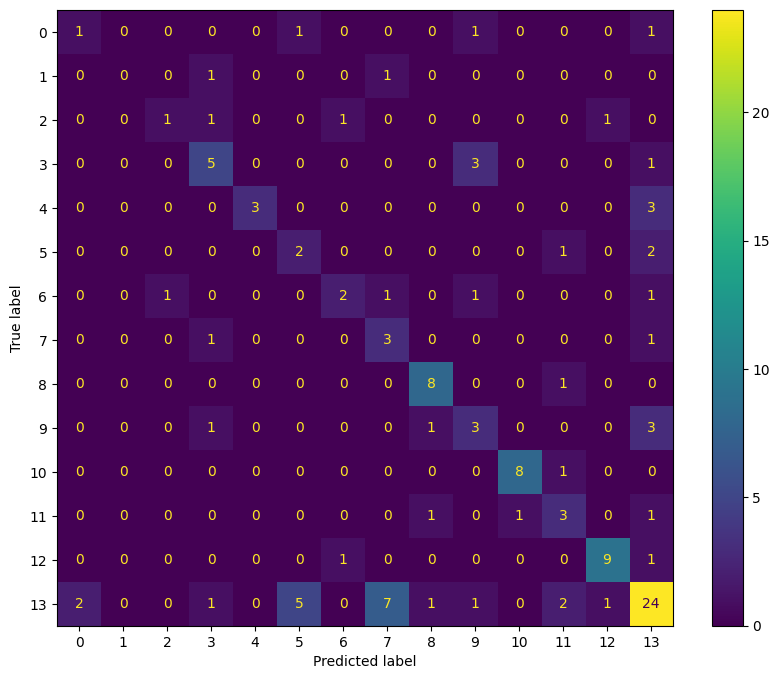

In [ ]:
output_metrics(model_3_2, experiment_3_2_test_data, experiment_3_2_test_labels)
plot_confusion_matrix(model_3_2, experiment_3_2_test_data, experiment_3_2_test_labels)

# Evaluation

## Loss

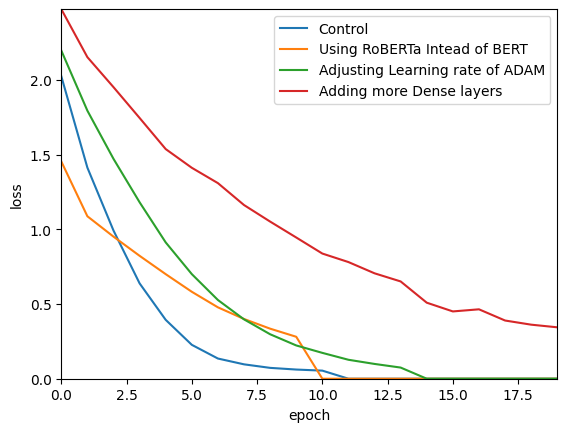

['0.00e+00', '0.00e+00', '0.00e+00', '3.44e-01']


In [ ]:
control_loss = np.array(control_history["loss"])
experiment_3_loss = np.array(experiment_3_history["loss"])
experiment_3_1_loss = np.array(experiment_3_1_history["loss"])
experiment_3_2_loss = np.array(experiment_3_2_history["loss"])

max_length = max(len(control_loss), len(experiment_3_loss), len(experiment_3_1_loss), len(experiment_3_2_loss))

control_loss_padded = np.pad(control_loss, (0, max_length - len(control_loss)), mode='constant')
experiment_3_loss_padded = np.pad(experiment_3_loss, (0, max_length - len(experiment_3_loss)), mode='constant')
experiment_3_1_loss_padded = np.pad(experiment_3_1_loss, (0, max_length - len(experiment_3_1_loss)), mode='constant')
experiment_3_2_loss_padded = np.pad(experiment_3_2_loss, (0, max_length - len(experiment_3_2_loss)), mode='constant')

plot_graphs([control_loss_padded, experiment_3_loss_padded, experiment_3_1_loss_padded, experiment_3_2_loss_padded], name="loss", legend=["Control", "Using RoBERTa Intead of BERT", "Adjusting Learning rate of ADAM", "Adding more Dense layers"])


## Validation Loss

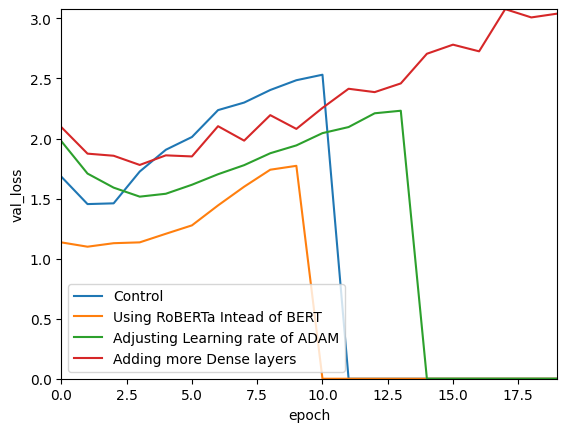

['0.00e+00', '0.00e+00', '0.00e+00', '3.04e+00']


In [ ]:
control_val_loss = np.array(control_history["val_loss"])
experiment_3_val_loss = np.array(experiment_3_history["val_loss"])
experiment_3_1_val_loss = np.array(experiment_3_1_history["val_loss"])
experiment_3_2_val_loss = np.array(experiment_3_2_history["val_loss"])

max_length = max(len(control_val_loss), len(experiment_3_val_loss), len(experiment_3_1_val_loss), len(experiment_3_2_val_loss))

control_val_loss_padded = np.pad(control_val_loss, (0, max_length - len(control_val_loss)), mode='constant')
experiment_3_val_loss_padded = np.pad(experiment_3_val_loss, (0, max_length - len(experiment_3_val_loss)), mode='constant')
experiment_3_1_val_loss_padded = np.pad(experiment_3_1_val_loss, (0, max_length - len(experiment_3_1_val_loss)), mode='constant')
experiment_3_2_val_loss_padded = np.pad(experiment_3_2_val_loss, (0, max_length - len(experiment_3_2_val_loss)), mode='constant')

plot_graphs([control_val_loss_padded, experiment_3_val_loss_padded, experiment_3_1_val_loss_padded, experiment_3_2_val_loss_padded], name="val_loss", legend=["Control", "Using RoBERTa Intead of BERT", "Adjusting Learning rate of ADAM", "Adding more Dense layers"])


## Accuracy

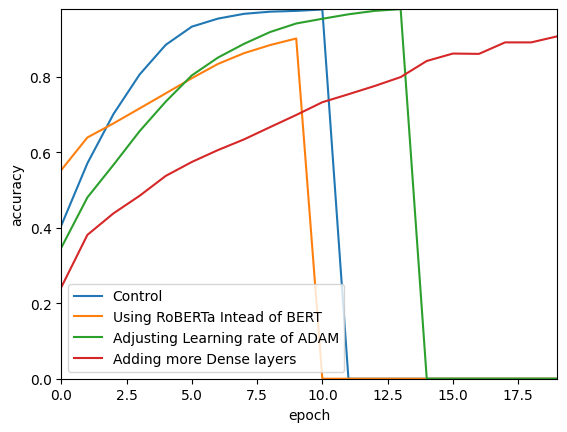

['0.00e+00', '0.00e+00', '0.00e+00', '9.08e-01']


In [ ]:
control_accuracy = np.array(control_history["accuracy"])
experiment_3_accuracy = np.array(experiment_3_history["accuracy"])
experiment_3_1_accuracy = np.array(experiment_3_1_history["accuracy"])
experiment_3_2_accuracy = np.array(experiment_3_2_history["accuracy"])

max_length = max(len(control_accuracy), len(experiment_3_accuracy), len(experiment_3_1_accuracy), len(experiment_3_2_accuracy))

control_accuracy_padded = np.pad(control_accuracy, (0, max_length - len(control_accuracy)), mode='constant')
experiment_3_accuracy_padded = np.pad(experiment_3_accuracy, (0, max_length - len(experiment_3_accuracy)), mode='constant')
experiment_3_1_accuracy_padded = np.pad(experiment_3_1_accuracy, (0, max_length - len(experiment_3_1_accuracy)), mode='constant')
experiment_3_2_accuracy_padded = np.pad(experiment_3_2_accuracy, (0, max_length - len(experiment_3_2_accuracy)), mode='constant')

plot_graphs([control_accuracy_padded, experiment_3_accuracy_padded, experiment_3_1_accuracy_padded, experiment_3_2_accuracy_padded], name="accuracy", legend=["Control", "Using RoBERTa Intead of BERT", "Adjusting Learning rate of ADAM", "Adding more Dense layers"])
